# **Задача бинарной классификации**

**В этой задаче классификации цель — предсказать подписки клиентов на срочные депозиты банка с использованием информации о последнем контакте и истории взаимодействия.**

Описание характеристик (признаков) пассажира:
1. **age** - возраст клиента
2. **job** - должность на работе
3. **marital** - семейное положение
4. **education** - уровень образования
5. **default** - просрочен ли кредит
6. **balance** - среднегодовой баланс
7. **housing** - есть ли жилищный кредит
8. **loan** - есть ли обычный кредит
9. **contact** - тип связи для контакта
10. **day** - день для связи
11. **month** - месяц для связи
12. **duration** - продолжительность контакта
13. **campaign** - количество контактов, осуществленных в ходе данной кампании с клиентом
14. **pdays** - количество дней, прошедших с момента последнего контакта с клиентом
15. **previous** - количество контактов, выполненных до начала этой кампании
16. **poutcome** - итоги предыдущей маркетинговой кампании
17. **y** - оформил ли клиент срочный депозит?

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras import Model, Input
from keras.api.callbacks import ModelCheckpoint
from keras.api.layers import Input, Dense, Dropout
from keras.api.utils import to_categorical
import matplotlib.pyplot as plt

2024-10-10 23:57:27.040533: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 23:57:27.041287: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-10 23:57:27.044669: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-10 23:57:27.052949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 23:57:27.067520: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

## **1. Подготовка набора данных для обучения многослойного персептрона**

In [2]:
df = pd.read_csv('./res/train.csv', encoding='utf-8') # загрузка набора данных, используя библиотеку pandas
df # вывод набора данных

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [3]:
# Выполняем простое числовое кодирование категорий с помощью Label Encoding
# Label Encoding заключается в присвоении уникального числового значения каждой категории (0, 1, 2 и так далее).
# Этот метод особенно подходит, когда у категорий существует естественный порядок, например, низкий, средний, высокий.
# Однако ничто не мешает его использовать и для категорий без порядка, но в особых случаях есть риск, что это может ввести модель в заблуждение, думая что в категориях есть некий приоритет.

# Инициализируем объект для Label Encoding и применяем его к строковым категориальным переменным.

label_encoder = LabelEncoder()
df['job'] = label_encoder.fit_transform(df['job'])
df['marital'] = label_encoder.fit_transform(df['marital'])
df['education'] = label_encoder.fit_transform(df['education'])
df['contact'] = label_encoder.fit_transform(df['contact'])
df['month'] = label_encoder.fit_transform(df['month'])
df['poutcome'] = label_encoder.fit_transform(df['poutcome'])

# Преобразование признаков в бинарный вид:
df['default'] = df['default'].map({'no': 0, 'yes': 1})
df['housing'] = df['housing'].map({'no': 0, 'yes': 1})
df['loan'] = df['loan'].map({'no': 0, 'yes': 1})
df['y'] = df['y'].map({'no': 0, 'yes': 1})

In [4]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,9,1,2,0,825,0,0,0,17,9,977,3,-1,0,3,1
45207,71,5,0,0,0,1729,0,0,0,17,9,456,2,-1,0,3,1
45208,72,5,1,1,0,5715,0,0,0,17,9,1127,5,184,3,2,1
45209,57,1,1,1,0,668,0,0,1,17,9,508,4,-1,0,3,0


In [5]:
# Определяем целевую переменную y и признаки X
y = df['y']
X = df.drop(['y', 'age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact'], axis=1)

In [6]:
# Масштабирование данных (стандартизация или нормализация)
# Масштабирование данных применяется только количественным непрерывным переменным

# Используем нормализацию для приведения значений в диапазон от 0 до 1.
minmax_scaler = MinMaxScaler()
quantitative_cols = ['duration', 'campaign', 'pdays', 'previous'] # Определение списка количественных переменных
X[quantitative_cols] = minmax_scaler.fit_transform(X[quantitative_cols])

In [7]:
X

,day,month,duration,campaign,pdays,previous,poutcome
0,5,8,0.053070,0.000000,0.000000,0.000000,3
1,5,8,0.030704,0.000000,0.000000,0.000000,3
2,5,8,0.015453,0.000000,0.000000,0.000000,3
3,5,8,0.018707,0.000000,0.000000,0.000000,3
4,5,8,0.040260,0.000000,0.000000,0.000000,3
...,...,...,...,...,...,...,...
45206,17,9,0.198658,0.032258,0.000000,0.000000,3
45207,17,9,0.092721,0.016129,0.000000,0.000000,3
45208,17,9,0.229158,0.064516,0.212156,0.010909,2
45209,17,9,0.103294,0.048387,0.000000,0.000000,3


In [8]:
# Переводим целевую переменную y и признаки X в numpy массивы
y = y.values
X = X.values

In [9]:
print("Количество объектов: " + str(X.shape[0]))
print("Количество признаков: " + str(X.shape[1]))
input_shape = X.shape[1] # размер входа нейронной сети, определяется по кол-ву признаков

Количество объектов: 45211
Количество признаков: 7


In [10]:
# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **2. Создание и обучение собственной модели многослойного персептрона**

In [11]:
def createModel(input_shape):
  input_x = Input(shape=(input_shape, ))       # для создания модели необходимо предопределить вход и размерность входных данных input_shape
  fc1 = Dense(128, activation='relu')(input_x) # добавляем скрытый слой с 128 нейронами с функцией активации ReLU
  fc2 = Dense(64, activation='relu')(fc1)      # добавляем второй скрытый слой с 64 нейронами с функцией активации ReLU
  out = Dense(1, activation='sigmoid')(fc2)    # добавляем выходной слой с 1 нейроном и сигмоидной функцией активации для бинарной классификации
  return Model(inputs=input_x, outputs=out)    # создаём модель, задавая вход и выход и возвращаем эту модель для последующих манипуляций

def trainModel(X_train, y_train):
  # Сохранение только наилучшей модели с наименьшей ошибкой на валидации
  save_callback = ModelCheckpoint(filepath='./out_bank/best_model.weights.h5',  # путь и название файла лучшей модели.
                                  monitor = 'val_loss',  # отслеживать каждую эпоху показать val_loss
                                  save_best_only = True,  # сохранять только самую лучшую модель
                                  save_weights_only=True,  # сохранять только веса модели (не всю модель);
                                  mode = 'min',  # режим оптимизации min (найти минимальную ошибку)
                                  verbose=1)                        # 1 означает выводить информацию о нахождении и сохранении лучшей модели в процессе обучения, 0 означает не выводить.

  model = createModel(input_shape) # создаётся модель принимающая на вход входные сигналы с размерностью input_shape

  # Компиляция модели
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # алгоритм градиентного спуска, минимизирующий функцию ошибки. В нём можно задать скорость обучения (по умолчанию 0.001)
                loss='binary_crossentropy',                              # функция ошибки binary_crossentropy бинарная кроссэнтропия для задачи бинарной классификации (0 или 1)
                metrics=['accuracy'])                                    # метрика accuracy - точность. Формула: отношение правильных предсказаний на общее количество предсказаний

  model.summary() # вывод информации о созданной модели

  model.fit(x=X_train,                  # признаки X
            y=y_train,                  # желаемый выход y
            epochs=200,                 # количество эпох обучения. эпоха представляет собой один полный проход через все данные обучающего набора.
            batch_size=256,             # параметр, с помощью которого можно регулировать порцию подаваемых примеров для сети за одну итерацию обучения (по-умолчанию он равен 32).
            validation_split=0.1,       # добавим валидационные данные (10% от обучающего набора) для проверки работоспособности сети на незнакомых данных каждую эпоху, чтобы отслеживать процесс возможного возникновения переобучения нейронной сети
            callbacks=[save_callback]   # используем в процессе обучения созданный ModelCheckpoint
            )
  return model # обученная модель возвращается для тестирования и других манипуляций

In [12]:
# Запуск обучения нейронной сети
model = trainModel(X_train, y_train)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,345 (36.50 KB)

 Trainable params: 9,345 (36.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
 64/128 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.8835 - loss: 0.3893  
Epoch 1: val_loss improved from inf to 0.34892, saving model to ./out_bank/best_model.weights.h5
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8835 - loss: 0.3769 - val_accuracy: 0.8869 - val_loss: 0.3489
Epoch 2/200
 78/128 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.8829 - loss: 0.3514
Epoch 2: val_loss improved from 0.34892 to 0.32124, saving model to ./out_bank/best_model.weights.h5
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.8827 - loss: 0.3486 - val_accuracy: 0.8869 - val_loss: 0.3212
Epoch 3/200
 74/128 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.8871 - loss: 0.3228
Epoch 3: val_loss improved from 0.32124 to 0.29799, saving model to ./out_bank/best_model.weights.h5
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.8860 - loss: 0.3220 - val_accuracy: 0.8872 - val_loss: 0.2980
Epoch 4/200
 78/128 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - accuracy: 0.8855 - l

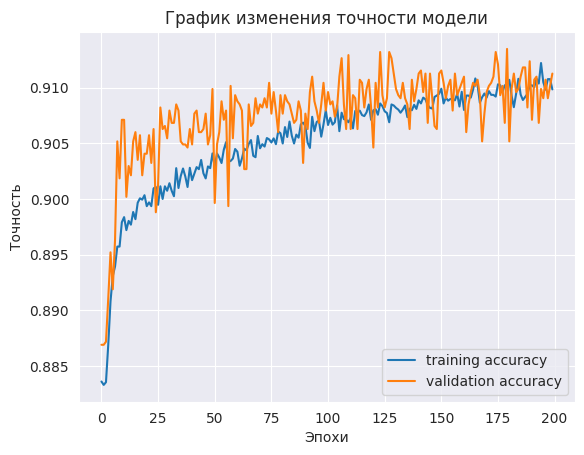

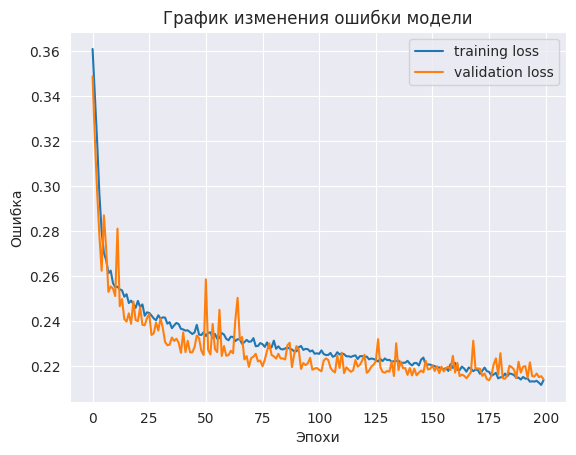

In [13]:
plt.figure()
plt.plot(model.history.history["accuracy"], label="training accuracy")
plt.plot(model.history.history["val_accuracy"], label="validation accuracy")
plt.legend()
plt.title("График изменения точности модели")
plt.xlabel("Эпохи")
plt.ylabel("Точность")
plt.show()

plt.figure()
plt.plot(model.history.history["loss"], label="training loss")
plt.plot(model.history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("График изменения ошибки модели")
plt.xlabel("Эпохи")
plt.ylabel("Ошибка")
plt.show()

In [14]:
# Загрузка весов самой лучшей модели с самой маленькой ошибкой на валидации
model.load_weights('./out_bank/best_model.weights.h5')

In [15]:
# Тестирование модели на тестовых данных
mlp_loss, mlp_accuracy = model.evaluate(X_test, y_test)
print("Точность модели MLP: " + str(mlp_accuracy))

283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.9021 - loss: 0.2360
Точность модели MLP: 0.9014707803726196


## **3. Обучение классических классификаторов машиннного обучения из библиотеки sklearn и сравнение с разработанным многослойным персептроном**

In [16]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Обучение и тестирование алгоритма LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)
print("Classification Report for LogisticRegression")
print(classification_report(y_test, log_reg_pred))

# Обучение и тестирование алгоритма KNN с параметрами по-умолчанию.
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print("Classification Report for KNeighborsClassifier")
print(classification_report(y_test, knn_pred))

# Обучение и тестирование алгоритма Random Forest с параметрами по-умолчанию.
random_forset = RandomForestClassifier()
random_forset.fit(X_train, y_train)
random_forset_pred = random_forset.predict(X_test)
print("Classification Report for RandomForestClassifier")
print(classification_report(y_test, random_forset_pred))

# Тестирование Multilayer Perceptron
mlp_pred = (model.predict(X_test).flatten() >= 0.5).astype(int) # осуществляем предсказание классов для тестовых данных и применяем решающее правило для выходных вероятностей
print("Classification Report for Our Multilayer Perceptron")
print(classification_report(y_test, mlp_pred.flatten()))

Classification Report for LogisticRegression
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      7952
           1       0.59      0.15      0.25      1091

    accuracy                           0.89      9043
   macro avg       0.74      0.57      0.59      9043
weighted avg       0.86      0.89      0.85      9043

Classification Report for KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      7952
           1       0.57      0.42      0.49      1091

    accuracy                           0.89      9043
   macro avg       0.75      0.69      0.71      9043
weighted avg       0.88      0.89      0.89      9043

Classification Report for RandomForestClassifier
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      7952
           1       0.61      0.44      0.51      1091

    accuracy                           0.

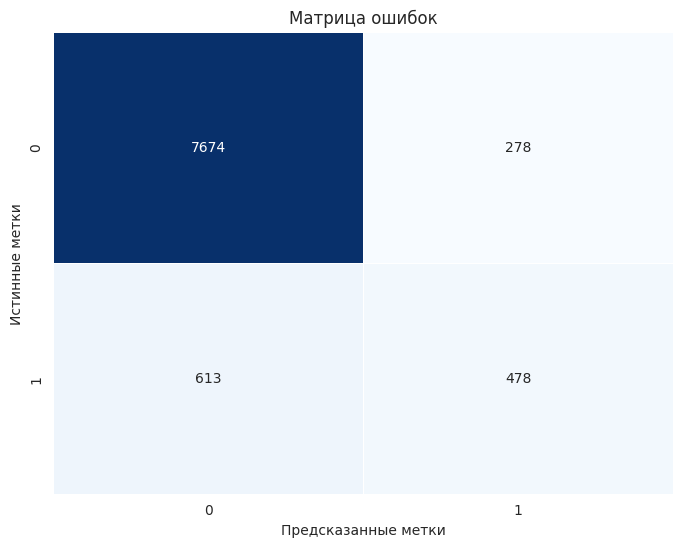

In [17]:
from sklearn.metrics import confusion_matrix

# Построим матрицу ошибок для оценки качества классификационной модели
# Матрица ошибок имеет вид таблицы, где:
# Строки представляют фактические классы (истинные метки),
# Столбцы представляют предсказанные классы (то, что модель предсказала).
cm = confusion_matrix(y_test, mlp_pred)

cm_df = pd.DataFrame(cm,
                     index=np.unique(y_test),
                     columns=np.unique(y_test))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5)
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.show()